 # Software Project : Tchernobyl test zone :

- conda create -n software python=3.11.5
- conda activate software
- pip install ipykernel #VS code kernel library
- pip install pandas
- pip install tqdm
- pip install requests
- pip install beautifulsoup4
- pip install matplotlib
- pip install seaborn
- pip install lxml

## 1.0°/ Initialization :

In [1]:
# Base import
import pandas as pd
import numpy as np

# Webo scrappo
#import requests
#import urllib.request
#from bs4 import BeautifulSoup

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set up path between folder to call our functions 
import sys
sys.path.append('..')
sys.path.append('../src')
sys.path.append('../datasets')

# Code aesthetic
import tqdm
import warnings

warnings.filterwarnings('ignore')

In [2]:
years = ['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
str = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'

# We can make use our app to make comparison through the years
for year in years:
    url = str.format(year)
    print(url)

https://www.basketball-reference.com/leagues/NBA_2016_per_game.html
https://www.basketball-reference.com/leagues/NBA_2017_per_game.html
https://www.basketball-reference.com/leagues/NBA_2018_per_game.html
https://www.basketball-reference.com/leagues/NBA_2019_per_game.html
https://www.basketball-reference.com/leagues/NBA_2020_per_game.html
https://www.basketball-reference.com/leagues/NBA_2021_per_game.html
https://www.basketball-reference.com/leagues/NBA_2022_per_game.html
https://www.basketball-reference.com/leagues/NBA_2023_per_game.html
https://www.basketball-reference.com/leagues/NBA_2024_per_game.html


In [3]:
url = str.format(years[-1])

r = pd.read_html(url, header = 0)

# This request output a list of dataframe read from the url, let's select the correct one :
# r[0] => regular season /// r[1] => playoffs
df = r[0]
df.head()

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards
0,1.0,Joel Embiid,29.0,PHI,C,39.0,39.0,33.6,11.5,21.8,...,2.4,8.6,11.0,5.6,1.2,1.7,3.8,2.9,34.7,AS
1,2.0,Luka Dončić,24.0,DAL,PG,70.0,70.0,37.5,11.5,23.6,...,0.8,8.4,9.2,9.8,1.4,0.5,4.0,2.1,33.9,"MVP-3,CPOY-6,AS,NBA1"
2,3.0,Giannis Antetokounmpo,29.0,MIL,PF,73.0,73.0,35.2,11.5,18.8,...,2.7,8.8,11.5,6.5,1.2,1.1,3.4,2.9,30.4,"MVP-4,DPOY-9,CPOY-12,AS,NBA1"
3,4.0,Shai Gilgeous-Alexander,25.0,OKC,PG,75.0,75.0,34.0,10.6,19.8,...,0.9,4.7,5.5,6.2,2.0,0.9,2.2,2.5,30.1,"MVP-2,DPOY-7,CPOY-3,AS,NBA1"
4,5.0,Jalen Brunson,27.0,NYK,PG,77.0,77.0,35.4,10.3,21.4,...,0.6,3.1,3.6,6.7,0.9,0.2,2.4,1.9,28.7,"MVP-5,CPOY-5,AS,NBA2"


## 2.0°/ Cleaning :

### Small cleaning :

In [4]:
#===================================================
#== Problems specific to a unique row or column : ==
#===================================================

# The last rows contains average of all players => useless
# df.loc[df['Rk'].isna()] => return an empty row
df = df.drop(735)

# Most player don't have an award => give them the super awards "No awards"
# df['Awards'].isna().sum() => no award means empty row
df['Awards'] = df['Awards'].fillna('No awards')

# The columns G and GS are float, even though all number are int
# df.dtypes
df[['G', 'GS']] = df[['G', 'GS']].astype('int32')

### Missing values :

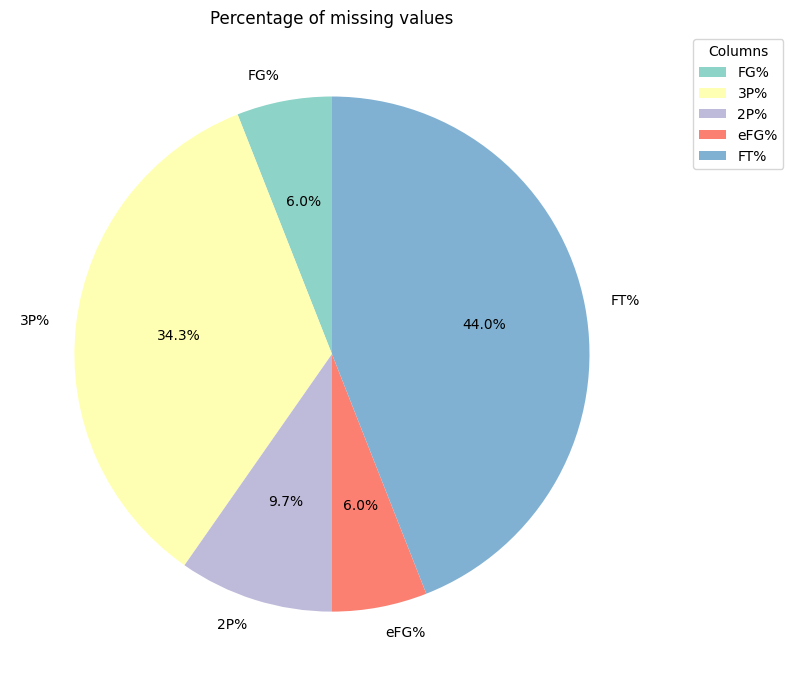

In [5]:
#=======================================================
#== Find the NaN value throughout our df ==
#=======================================================

# Most missing value come from the fact that some players switched teams during the season
missing = df.isna().sum()

missing = missing[missing > 0]

colors = plt.cm.Set3.colors

plt.figure(figsize=(8, 8))
plt.pie(
    missing,
    labels=missing.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors[:len(missing)]
)

plt.title("Percentage of missing values")
plt.legend(
    missing.index,
    title="Columns",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()

In [6]:
# Truth be told, there is no way to recover those missing data
# So let's just set them up to 0, the ranking argument is the points scored 'PTS', so it shouldn't be a problem for our futur uses. 
# missing.index => ctrl + c & ctrl + v
df[['FG%', '3P%', '2P%', 'eFG%', 'FT%']] = df[['FG%', '3P%', '2P%', 'eFG%', 'FT%']].fillna(0.0)

### Player switching team problem :

Some of the players played on 2/3+ differents teams during the season, meaning they got 2 rows (with the same rank though). But for most of them they end up with almost no games played on their new teams, meaning empty value.
To fill these empty rows, some options appears before us :
- Drop the "teams column" and averaging their score while keeping the coefficient by "game played.
- Keep the "teams column" but keep only their most played team score and enhance them with their other team score (so that the rank can be justified).
- Keep the "teams column" but drop their less played team score, could lead to problem with their global ranking.

In [7]:
duplicate = df[df.duplicated(subset=['Rk', 'Player'], keep=False)]
nb_duplicate_rows = duplicate.shape[0]
nb_player_duplicate = duplicate['Player'].nunique()

print(f"Number of duplicate rows : {nb_duplicate_rows}.\nNumber of of player that switched teams : {nb_player_duplicate}.")

Number of duplicate rows : 241.
Number of of player that switched teams : 78.


In [8]:
# Get df columns and copy past
#df.columns
# Need to be used as key when GROUP BY
id_col = ['Rk', 'Player', 'Age']
# Need to find the category he played the most
categorical_col = ['Team', 'Pos', 'Awards']
# Need to SUM these columns when GROUP BY
int_col = ['G', 'GS']
# Need to AVG these columns by game played when GROUP BY
float_col = ['MP', 'FG', 'FGA','FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']


In [9]:
def weighted_avg(series, weights):
    return np.average(series, weights=weights)

def most_games_category(df, col):
    return df.loc[df['G'].idxmax(), col]

In [10]:
agg_dict = {}

# Sum integer columns
for col in int_col:
    agg_dict[col] = 'sum'

# Weighted average float columns
for col in float_col:
    agg_dict[col] = lambda x, c=col: weighted_avg(x, df.loc[x.index, 'G'])

df_grouped = (
    df
    .groupby(id_col, as_index=False)
    .agg(agg_dict)
)

for col in categorical_col:
    df_grouped[col] = (
        df
        .groupby(id_col)
        .apply(lambda x: most_games_category(x, col))
        .values
    )

final_cols = id_col + categorical_col + int_col + float_col
df_grouped = df_grouped[final_cols]

In [11]:
# I used this specific guys to check my function worked correctly
df_grouped.iloc[543:544]

,Rk,Player,Age,Team,Pos,Awards,G,GS,MP,FG,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
543,544.0,Filip Petrušev,23.0,2TM,C,No awards,6,0,3.316667,0.316667,...,0.416667,0.0,0.316667,0.316667,0.0,0.0,0.0,0.0,0.316667,1.0
